In [49]:
import gym
import numpy as np 
from itertools import count
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import sklearn.pipeline
import sklearn.preprocessing

import sys
if "../" not in sys.path:
  sys.path.append("../") 

from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler

env = gym.envs.make("MountainCar-v0")
env._max_episode_steps = 2000


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/mquan/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


## Value Fucntion Approximator

In [50]:
class ValueApprox(object):
    def __init__(self, num_features):
        self.weights = np.zeros(num_features)
        num_components = num_features // 4
        observation_examples = np.array([env.observation_space.sample() for x in range(1000)])
        # define scaler
        self.scaler = sklearn.preprocessing.StandardScaler()
        self.scaler.fit(observation_examples)
        # define featurizer
        self.featurizer = state_featurizer = sklearn.pipeline.FeatureUnion([
                ("rbf1", RBFSampler(gamma=5.0, n_components=num_components)),
                ("rbf2", RBFSampler(gamma=2.0, n_components=num_components)),
                ("rbf3", RBFSampler(gamma=1.0, n_components=num_components)),
                ("rbf4", RBFSampler(gamma=0.5, n_components=num_components))
                ])
        self.featurizer.fit(self.scaler.transform(observation_examples))
    
    def featurize_state(self, state):
        scaled = self.scaler.transform([state])
        featurized = self.featurizer.transform(scaled)
        return featurized[0]
    
    def cal_state_value(self, state):
        return self.featurize_state(state).dot(self.weights)
    
    def update_weights(self, learning_rate, td_error, state):
        self.weights += learning_rate * td_error * self.featurize_state(state)

# test
value_func = ValueApprox(8)
state = env.observation_space.sample()
print("ex features vector:\n",value_func.featurize_state(state))
print("ex state value:\n", value_func.cal_state_value(state))

ex features vector:
 [-0.93296662  0.77575578  0.52555347  0.07342372  0.93765085  0.99254739
 -0.60019778 -0.97697538]
ex state value:
 0.0


## Softmax Policy

In [51]:
class Policy(object):
    def __init__(self, num_features):
        self.weights = np.zeros(num_features)
        num_components = num_features // 4
        observation_examples = np.array([env.observation_space.sample() for x in range(1000)])
        action_examples = np.array([env.action_space.sample() for x in range(1000)])
        obs_act_examples = np.concatenate((observation_examples, action_examples.reshape((-1, 1))), axis=1)
        # define scaler
        self.scaler = sklearn.preprocessing.StandardScaler()
        self.scaler.fit(obs_act_examples)
        # define featurizer
        self.featurizer = state_featurizer = sklearn.pipeline.FeatureUnion([
                ("rbf1", RBFSampler(gamma=5.0, n_components=num_components)),
                ("rbf2", RBFSampler(gamma=2.0, n_components=num_components)),
                ("rbf3", RBFSampler(gamma=1.0, n_components=num_components)),
                ("rbf4", RBFSampler(gamma=0.5, n_components=num_components))
                ])
        self.featurizer.fit(self.scaler.transform(obs_act_examples))
        self.score = None
    
    def featurize_state_action(self, state, action):
        scaled = self.scaler.transform([np.append(state, action)])
        featurized = self.featurizer.transform(scaled)
        return featurized[0]
    
    def choose_action(self, state):
        '''
        Choose an action at state s & calculate the score of this action (grad of log(policy))
        the score is stored in attribute score
        '''
        act_prob = np.zeros(env.action_space.n)
        features_mat = np.zeros((env.action_space.n, self.weights.shape[0]))
        for act in range(env.action_space.n):
            features_mat[act, :] = self.featurize_state_action(state, act)
            act_prob[act] = np.exp(features_mat[act, :].dot(self.weights))
        act_prob /= act_prob.sum()  # normalize act_prob
        choosen_act = np.argmax(act_prob)
        self.score = features_mat[choosen_act, :] - features_mat.mean(axis=0)
        return choosen_act
    
    def update_weights(self, delta_w):
        self.weights += delta_w
    

# Test
policy = Policy(8)
action = env.action_space.sample()
print(policy.featurize_state_action(state, action))
act = policy.choose_action(state)
print("choose action:\t", act)
print("score:\n", policy.score)

[0.99714423 0.35997454 0.74379398 0.95281359 0.20840511 0.34334048
 0.81340239 0.99356823]
choose action:	 0
score:
 [ 0.78667378  0.34494707  0.67183394  1.00586787  0.58469103 -0.37959927
  0.69453387 -0.00385811]


## Hyperparameters & Statistic

In [55]:
num_features = 4*10
alpha = 1e-3
beta = 1e-3
gamma = 0.99

steps_per_episode = []

In [56]:
def plotValueFunc(value_approx):
    x_vect = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=50)
    xdot_vect = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=50)
    x, xdot = np.meshgrid(x_vect, xdot_vect)
    state_value = np.zeros(x.shape)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            state = np.array([x[i, j], xdot[i, j]])
            state_value[i, j] = value_approx.cal_state_value(state)
    # plot Value function
    fig = plt.figure(100)
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(x, xdot, -state_value, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('Value')
    ax.set_title("Mountain \"Cost To Go\" Function")
    plt.show()

## Training Loop

In [64]:
# Create policy object & value approx. object
policy = Policy(num_features)
value_approx = ValueApprox(num_features)

max_episode = 20
for i_episode in range(max_episode):
    state = env.reset()
    action = policy.choose_action(state)
    for step in count():
        next_state, reward, done, _ = env.step(action)
        if next_state[0] > 0.45:
            reward = 1.0
            done = True
        if not done:
            next_action = policy.choose_action(next_state)
            td_error = reward + gamma * value_approx.cal_state_value(next_state) - \
                                        value_approx.cal_state_value(state)
        else:
            next_action = None
            td_error = reward - value_approx.cal_state_value(state)
        # Update weight of Actor & Critic
        policy.update_weights(alpha * td_error * policy.score)
        value_approx.update_weights(beta, td_error, state)
        if done:
            print("Episode %d finishes after %d steps" % (i_episode, step + 1))
            break
        else:
            if step % 500 == 0: print("Episode %d\tTD error = " % i_episode, td_error)
        # move on
        action = next_action
        state = next_state
    steps_per_episode.append(step)
    

Episode 0	TD error =  -1.0
Episode 0	TD error =  -0.984943514559188
Episode 0	TD error =  -0.9653874166333578
Episode 0	TD error =  -0.9887149424158332
Episode 0 finishes after 2000 steps
Episode 1	TD error =  -0.9328086944091494
Episode 1	TD error =  -0.9061412703268434
Episode 1	TD error =  -0.8779676497610502
Episode 1	TD error =  -0.8129569241552854
Episode 1 finishes after 2000 steps
Episode 2	TD error =  -0.8203282176743603
Episode 2	TD error =  -0.8405952372541208
Episode 2	TD error =  -0.8784927238155511
Episode 2	TD error =  -0.3654789508252403
Episode 2 finishes after 2000 steps
Episode 3	TD error =  -0.8102478968271463
Episode 3	TD error =  -0.7308520612872655
Episode 3	TD error =  -0.7781554207230101
Episode 3	TD error =  -0.41943416526974175
Episode 3 finishes after 2000 steps
Episode 4	TD error =  -0.5196588269857969
Episode 4	TD error =  -0.5996121937460508
Episode 4	TD error =  -1.4344202942954105
Episode 4 finishes after 1365 steps
Episode 5	TD error =  -0.513546303260

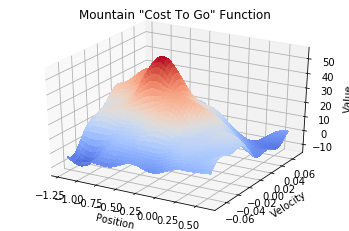

In [65]:
plotValueFunc(value_approx)

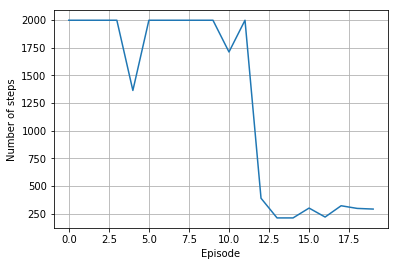

In [67]:
plt.figure(1)
plt.plot(steps_per_episode)
plt.grid()
plt.xlabel("Episode")
plt.ylabel("Number of steps")
plt.show()

In [68]:
np.savetxt('mountain_car_td_AC_policy_weights.txt', policy.weights, fmt='%f')